In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 각종 함수 구현해둔 file import
import calcRoadAngle

In [3]:
# 특정 경도와 위도 설정
latitude = "37.385808"
longitude = "126.646042"

In [4]:
"""
if os.path.exists(f'imgs/{latitude}_{longitude}.png'):  # 해당 경도 위도 값을 가지는 이미지가 있으면 불러옴
    img = cv2.imread(f'imgs/{latitude}_{longitude}.png')
else:                                                   # 이미지가 없는 경우 이미지를 받아옴
    data = calcRoadAngle.get_map_image(latitude, longitude) # 경도 위도 기반으로 이미지 데이터 request
    img = calcRoadAngle.bytes2img(data)                     # byte 데이터 image로 변환
    cv2.imwrite(f'imgs/{latitude}_{longitude}.png', img)
"""
files = [file for file in os.listdir('./imgs') if file.endswith('.png')]
imgs = []
for file in files:
    imgs.append(cv2.imread(f'imgs/{file}'))

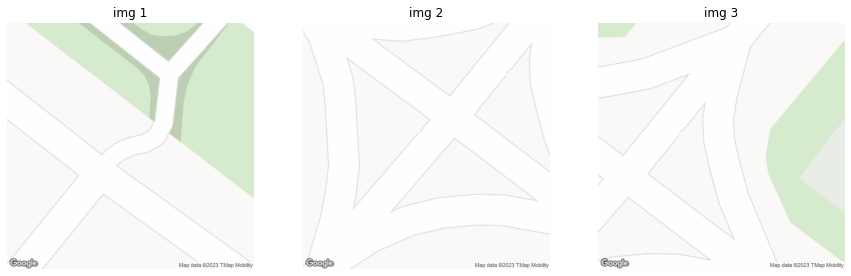

In [7]:
plt.figure(figsize=(15, 5))
for idx, img in enumerate(imgs):
    plt.subplot(1,3,1+idx)
    plt.imshow(img)
    plt.title(f'img {idx+1}')
    plt.axis('off')
plt.show()

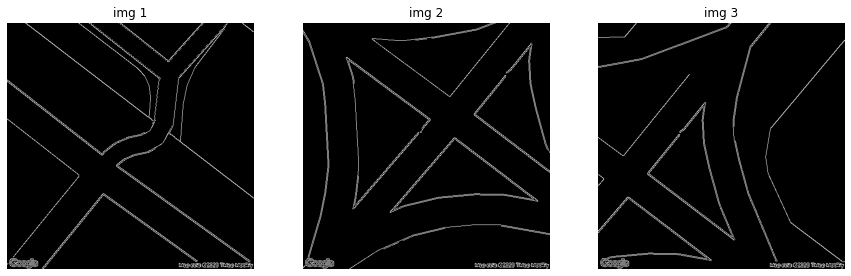

In [9]:
# edge detection 수행
edge_imgs = []
for img in imgs:
    edge_imgs.append(cv2.Canny(img, 100, 200))

plt.figure(figsize=(15, 5))
for idx, img in enumerate(edge_imgs):
    plt.subplot(1,3,1+idx)
    plt.imshow(img, cmap='gray')
    plt.title(f'img {idx+1}')
    plt.axis('off')
plt.show()

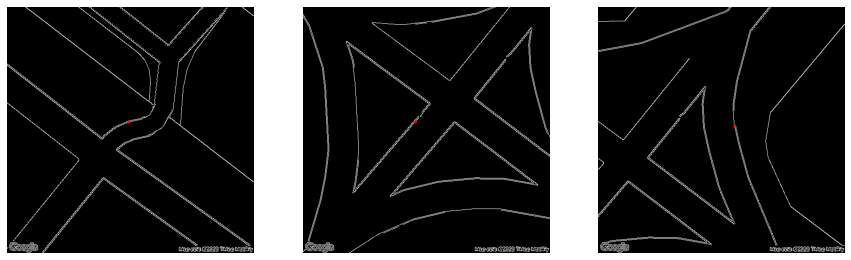

In [16]:
point_ = []
plt.figure(figsize=(15, 5))
for idx, edges in enumerate(edge_imgs):
    # 이미지의 정중앙(입력한 경도, 위도)에서 가장 가까운 Non-zero 값을 가지는 point를 찾는다
    point_.append(calcRoadAngle.find_closest_nonzero_point(edges))
    # 해당 점 이미지 위에 표시
    plt.subplot(1,3,1+idx)
    plt.imshow(cv2.cvtColor(calcRoadAngle.visualize_point(edges, point_[idx]), cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()

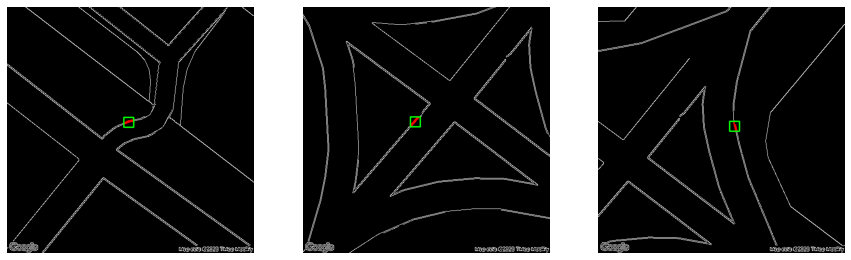

In [19]:
points = []
plt.figure(figsize=(15, 5))
for idx, point in enumerate(point_):
    # 위에서 구한 점에 특정 범위 이내에 있는 non-zero value를 가지는 점 추출 및 시각화
    points.append(calcRoadAngle.find_nonzero_in_window(edge_imgs[idx], point, kernel_size=20))
    plt.subplot(1,3,1+idx)
    tmp = cv2.cvtColor(calcRoadAngle.visualize_points(edge_imgs[idx], point, 20), cv2.COLOR_BGR2RGB)
    plt.imshow(tmp)
    plt.axis('off')
plt.show()

In [23]:
line_cfgs = []
angles = []
for idx, points_ in enumerate(points):
    # 해당 점들의 경향성을 가장 잘 나타내는 직선 찾기 (least square 기반)
    line_cfgs.append(calcRoadAngle.find_line_from_points(points_))
    # 해당 직선의 기울기 기반으로 각도 계산
    angles.append(np.rad2deg(np.arctan(line_cfgs[idx][0]))[0])
    print(f"The angle of road is {angles[idx]}°")

The angle of road is -19.201946258544922°
The angle of road is -48.770103454589844°
The angle of road is 75.43050384521484°


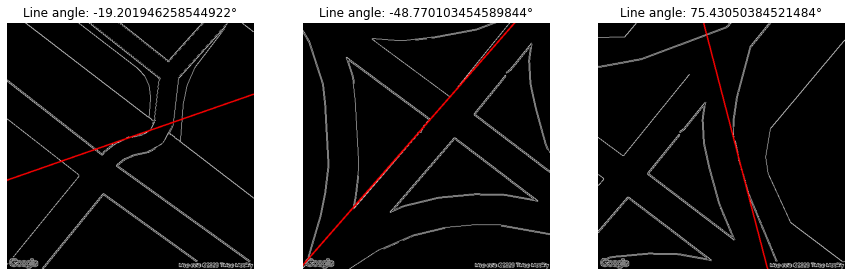

In [24]:
# 해당 직선 시각화
plt.figure(figsize=(15, 5))
for idx, cfg in enumerate(line_cfgs):
    slope, intercept = cfg
    tmp = calcRoadAngle.visualize_line(edge_imgs[idx], slope, intercept)
    tmp = cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB)
    plt.subplot(1,3,1+idx)
    plt.imshow(tmp)
    plt.title(f'Line angle: {angles[idx]}°')
    plt.axis('off')
plt.show()

Assumption 현재 코드는 위도와 경도가 도로 위에서 호출된다는 가정하에 작동함.

Algorithm flow
가장 가까운 도로 경계선 -> 주변 점 추출 -> line fitting -> 기울기 기반 각도 계산

일반적인 좌표계와 달리 y축이 뒤집어져 있는 형태임. 추가적으로 현재는 기울기 기반으로 계산하고 있기 때문에 예각만 찾거나 하는 기능은 빠져있음. 추후에 사용하기 편한 형태로 converting 하는거 하나 만들면 될 듯